# Doppler radar storm geo-analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import urllib.request
import time
from pylab import rcParams

Defining possible dBZ reflections gathered from Image analysis. Sorting them to pandas dataframe according to RGB values.

In [2]:
DHMZ_possible_reflections = [[0,255,255],[0,199,199],[0,146,145],[0,56,184],\
                             [0,129,0],[0,202,0],[41,255,10],[255,255,0],\
                             [237,194,0],[255,0,0],[247,0,219]]
df3 = pd.DataFrame(DHMZ_possible_reflections, columns = ['r','g','b'])

Defining starting time for radar data and adjusting it for data scrapping if needed.

In [3]:
hour = 12
minute = 55
day = 7
month = 7
year = 2019

if (int(month/10) == 0):
    month = '0' + str(month)

if (int(day/10) == 0):
    day = '0' + str(day)
    
if (int(hour/10) == 0):
    hour = '0' + str(hour)

2D array is needed here because radar data is pulled from map.

In [4]:
x_rain = [[0 for i in range(145)] for j in range(160)]
x_shower = [[0 for i in range(145)] for j in range(160)]
x_thunderstorm = [[0 for i in range(145)] for j in range(160)]
x_severe_storm = [[0 for i in range(145)] for j in range(160)]

Getting radar image for each 15-minute period and analysing it for possible reflections. According to that, each pixel is saved to particular 2D array, as defined above.

Each loop step also needs to check for time overlaps and adjust time accordingly.

iterations = number of 15 minute steps in analysis, for exampe if iterations = 9, two hours of radar data will be analysed (usually 5 seconds needed for each frame, recommended max is 25).

In [5]:
iterations = 13
k = 0

while (k <= iterations):
    urllib.request.urlretrieve('http://139.59.144.6/arhiva/bilogora_stat/{year}/{month}/{day}/'\
                               'bilogora_stat_{year}{month}{day}{hour}{minute}Z.png'\
                               .format(year = year, month = month, day = day, hour = hour, minute = minute),\
                               "bilogora-stat.png")
    
    im = Image.open("bilogora-stat.png")
    rgb_im = im.convert('RGB') 
    
    i = 0
    j = 0

    for i in range (105,250):
        for j in range (165,325):
            r, g, b = rgb_im.getpixel((i, j))
            if ((r == df3['r'][1] or r == df3['r'][2] or r == df3['r'][3]) and (g in df3['g'].values)):
                x_rain[j - 165][i - 105] = x_rain[j - 165][i - 105] + 1
            elif ((r == df3['r'][5] or r == df3['r'][6] or r == df3['r'][7]) and (g in df3['g'].values)):
                x_shower[j - 165][i - 105] = x_shower[j - 165][i - 105] + 1
            elif ((r == df3['r'][8] or r == df3['r'][9]) and (g in df3['g'].values)):
                x_thunderstorm[j - 165][i - 105] = x_thunderstorm[j - 165][i - 105] + 1
            elif ((r == df3['r'][10]) and (g in df3['g'].values)):
                x_severe_storm[j - 165][i - 105] = x_severe_storm[j - 165][i - 105] + 1
    
    if (minute == 55):
        minute = 10
        if (hour == 23):
            hour = 0
            if (day == 31):
                day = 1
                month = month + 1
        else:
            hour = hour + 1
    else:
        minute = minute + 15
    
    k = k + 1    
                
    time.sleep(1) 

Some masking needs to be done since city markings are also seen as possible reflections (rain).

In [6]:
i = 0
j = 0

for i in range(0,160):
    mask = max(x_rain[i])
    for j in range (0,145):
        if x_rain[i][j] == mask:
            x_rain[i][j] = 0

Uploading template image (blank map) and cropping it to show only central Croatia. Also defining custom colormap.

In [7]:
template = Image.open("template.png",'r')
template = template.crop((105,165,250,325))

def transparent_cmap(cmap, N = 255):
    mycmap = cmap
    mycmap._init()
    mycmap._lut[:,-2] = np.linspace(0, 1, N + 4)
    return mycmap

mycmap = transparent_cmap(plt.cm.rainbow)

w, h = template.size
y, x = np.mgrid[0:h, 0:w]

Adjusting 2D array to 1D in order to use it for plotting.

In [8]:
rain = np.ravel(x_rain)
shower = np.ravel(x_shower)
thunderstorm = np.ravel(x_thunderstorm)
severe_storm = np.ravel(x_severe_storm)

rcParams['figure.figsize'] = 10, 10  

Plotting data for rainy - pixels (10-35 dBZ).

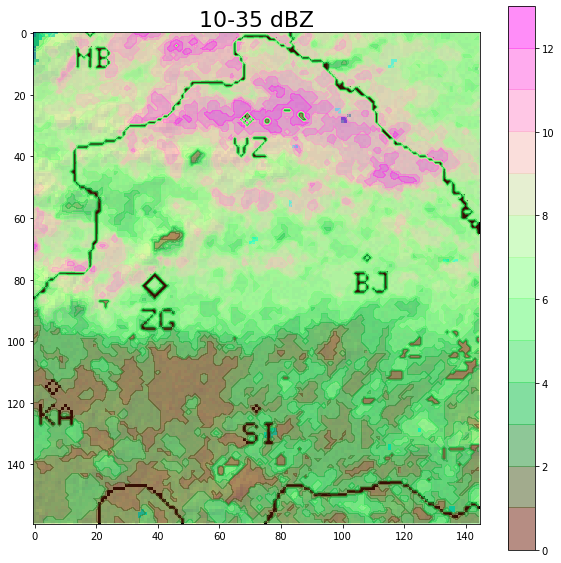

In [9]:
fig1, ax1 = plt.subplots(1, 1)

ax1.imshow(template)
cb1 = ax1.contourf(x, y, rain.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap, alpha = 0.5)
plt.colorbar(cb1)
plt.title('10-35 dBZ', fontsize = 22)
plt.show()

Plotting data for showery - pixels (35-50 dBZ).

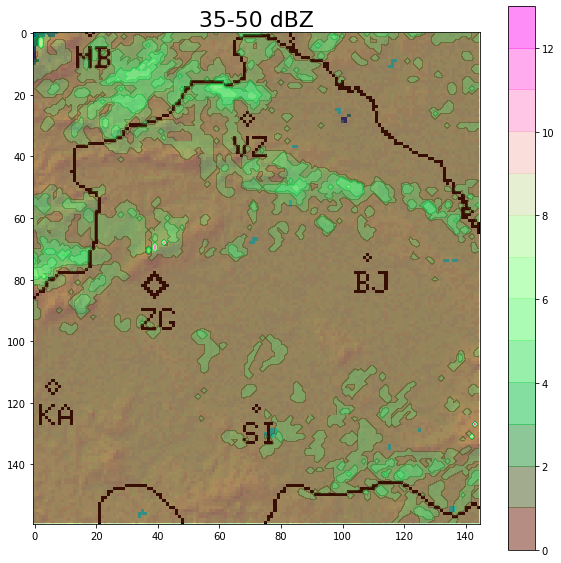

In [10]:
fig2, ax2 = plt.subplots(1, 1)

ax2.imshow(template)
cb2 = ax2.contourf(x, y, shower.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap, alpha = 0.5)
plt.colorbar(cb2)
plt.title('35-50 dBZ', fontsize = 22)
plt.show()

Plotting data for stormy - pixels (50-60 dBZ).

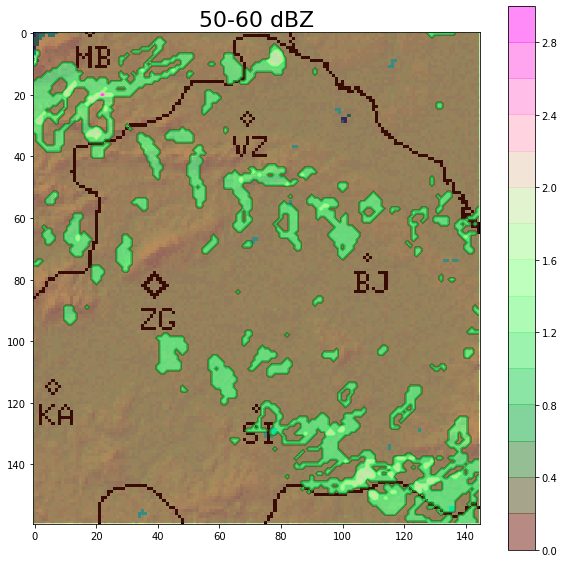

In [11]:
fig3, ax3 = plt.subplots(1, 1)

ax3.imshow(template)
cb3 = ax3.contourf(x, y, thunderstorm.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap, alpha = 0.5)
plt.colorbar(cb3)
plt.title('50-60 dBZ', fontsize = 22)
plt.show()

Plotting data for severe - stormy - pixels (60+ dBZ).

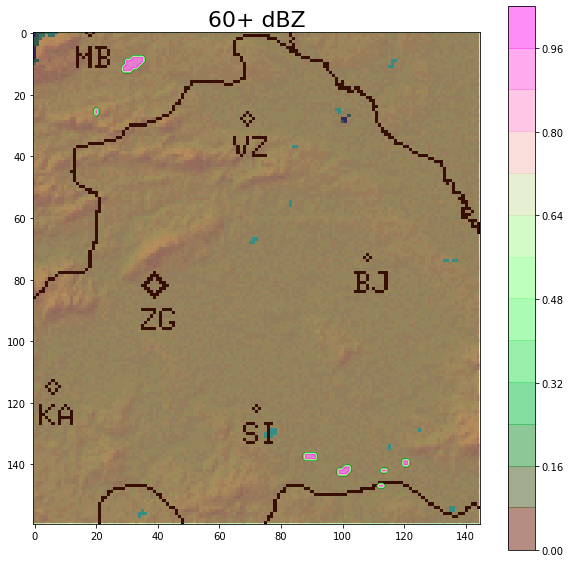

In [12]:
fig4, ax4 = plt.subplots(1, 1)

ax4.imshow(template)
cb4 = ax4.contourf(x, y, severe_storm.reshape(x.shape[0], y.shape[1]), 15, cmap=mycmap, alpha = 0.5)
plt.colorbar(cb4)
plt.title('60+ dBZ', fontsize = 22)
plt.show()

Verification for given time interval on this link:

http://139.59.144.6/arhiva/bilogora_anim/2019/07/07/bilogora_anim_201907071600Z.gif